In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import optax
from tqdm.notebook import tqdm

import jaxgp as jgp
from jaxgp.datasets import Dataset, CustomDataset, NumpyLoader

np.random.seed(42)

/Users/lichengk/.miniforge3/envs/py39_forge/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import logging
import tensorflow_probability.substrates.numpy as tfp

logger = logging.getLogger("root")

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()

logger.addFilter(CheckTypesFilter())


In [3]:
input_dim = 1
output_dim = 1
num_data = 1000
num_test = 1000
num_inducing = 20


def func(X):
    return np.sin(2 * X) + 0.3 * X + np.random.normal(0, 0.1, X.shape)


X = np.random.uniform(-3.0, 3.0, (num_data, input_dim))
Y = func(X)

key = jax.random.PRNGKey(10)

Xtest = jnp.sort(
    jax.random.uniform(key, shape=(num_test, input_dim), minval=-5, maxval=5),
    0,
)

In [4]:
mean = jgp.means.Quadratic()
kernel = jgp.kernels.RBF()
gprior = jgp.GPrior(kernel=kernel, mean_function=mean)
likelihood = jgp.likelihoods.Gaussian()
inducing_points = (
    jax.random.uniform(key=key, shape=(num_inducing, input_dim))
    * (X.max() - X.min())
    + X.min()
)
model = jgp.SVGP(gprior, likelihood, inducing_points, output_dim)

params, constrain_trans, unconstrain_trans = jgp.initialise(model)
raw_params = unconstrain_trans(params)
neg_elbo = model.build_elbo(num_data=num_data, sign=-1.0)



In [5]:
from jaxgp.utils import pytree_shape_info

In [6]:


def loss(raw_params):
    batch_size = num_data
    if num_data % batch_size != 0:
        raise ValueError("num_data need to be divisible by batch_size.")
    num_iters = num_data // batch_size
    neg_elbo_value = 0.
    for i in range(num_iters):
        batch = (X[i*batch_size : (i+1)*batch_size], Y[i*batch_size : (i+1)*batch_size])
        data = Dataset(X=batch[0], Y=batch[1])
        neg_elbo_value += neg_elbo(raw_params, data)
        i += 1
    return neg_elbo_value / i

In [7]:
print("Initial negative elbo = ", loss(raw_params))

Initial negative elbo =  3763.078332575452


In [9]:
pytree_shape_info(raw_params)

{'inducing_points': (20, 1), 'kernel': {'lengthscale': (1,), 'outputscale': (1,)}, 'likelihood': {'noise': ()}, 'mean_function': {'m0': (1,), 'scale': (1,), 'xm': (1,)}, 'q_mu': (20, 1), 'q_sqrt': (1, 210)}


In [ ]:
solver = jaxopt.LBFGS(fun=loss, verbose=True)
soln = solver.run(raw_params)

In [10]:
solver = jaxopt.ScipyMinimize(fun=loss, jit=True, options={"disp": True})
soln = solver.run(raw_params)

         Current function value: -860.044056
         Iterations: 45797
         Function evaluations: 47904
         Gradient evaluations: 47893


In [16]:
@jax.jit
@jax.value_and_grad
def loss_sgd(raw_params, batch):
    return neg_elbo(raw_params, batch)

batch_size = 50
training_data = CustomDataset(X, Y)
train_dataloader = NumpyLoader(
    training_data, batch_size=batch_size, shuffle=True
)
opt = optax.adam(learning_rate=1e-3)
opt_state = opt.init(raw_params)

num_epochs = 400
loss_history = []
for epoch in tqdm(range(num_epochs)):
    for batch in train_dataloader:
        data = Dataset(X=batch[0], Y=batch[1])
        loss_val, grads = loss_sgd(raw_params, data)
        updates, opt_state = opt.update(grads, opt_state)
        raw_params = optax.apply_updates(raw_params, updates)
    loss_history.append(loss_val.item())

  0%|          | 0/400 [00:00<?, ?it/s]

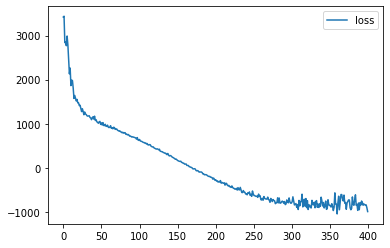

In [17]:
plt.figure()
plt.plot(loss_history, label="loss")
plt.legend()
plt.show()

In [19]:
loss(raw_params)

DeviceArray(-836.42316559, dtype=float64)

In [20]:
raw_params["q_sqrt"]

DeviceArray([[ 5.82068186e-01,  4.93282703e-02, -5.36462701e-02,
               1.19021663e-01, -1.31802779e-02, -3.86867078e-02,
              -2.38417262e-03, -5.66921426e-01,  1.70304368e-02,
               4.57260575e-02,  1.92021094e-01, -5.28586124e-02,
              -8.11382632e-02,  2.16701447e-02, -3.49428298e-01,
               1.83644469e-01,  2.01244929e-01, -3.57400855e-02,
               1.26161443e-02, -1.19384530e-01,  9.68854423e-03,
               9.81384855e-02, -6.75875741e-03,  1.06167677e-01,
              -7.76753140e-03,  5.02997250e-02,  8.99387890e-02,
              -5.49162448e-01, -5.61473407e-02, -8.13394265e-02,
              -2.92942895e-01,  8.27609070e-02,  4.16004950e-02,
              -6.80426471e-02,  2.03884828e-01, -2.46902017e-01,
              -3.05832406e-01,  2.49312281e-02,  1.68192551e-01,
               1.09255646e-01,  1.73489805e-02,  7.21265663e-01,
               1.47721067e-01,  1.96179187e-01,  2.38616949e-02,
              -3.45377756

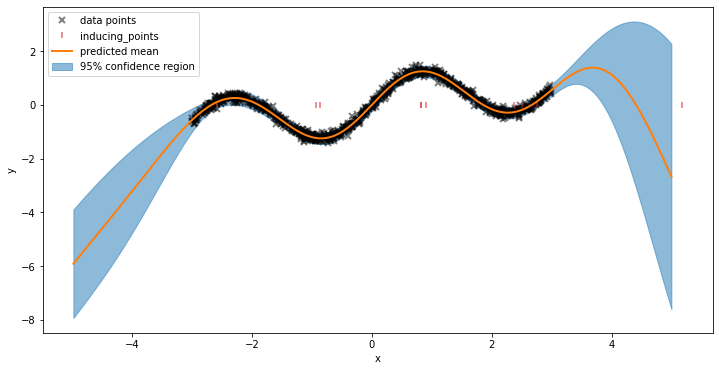

In [69]:
params = constrain_trans(raw_params)
plot_model(params)

In [14]:
def plot_model(params):
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2, alpha=0.5, label="data points")
    plt.plot(
        params["inducing_points"],
        jnp.zeros([num_inducing, input_dim]),
        "|",
        color="tab:red",
        mew=2,
        alpha=0.5,
        label="inducing_points",
    )
    mean, var = model.predict_y(params, Xtest)
    plt.plot(Xtest, mean, "tab:orange", lw=2, label="predicted mean")
    plt.fill_between(
        Xtest[:, 0],
        mean[:, 0] - 1.96 * jnp.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * jnp.sqrt(var[:, 0]),
        color="tab:blue",
        alpha=0.5,
        label="95% confidence region",
    )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    plt.xlim([-5, 5])
    plt.show()

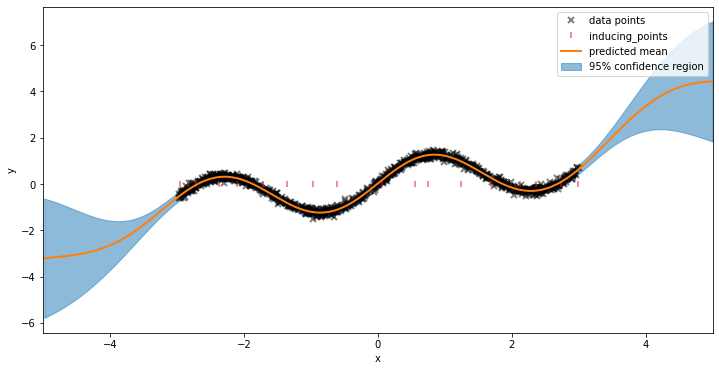

In [15]:
params = constrain_trans(soln.params)
plot_model(params)


In [22]:
loss(raw_params)

DeviceArray(3703.62440671, dtype=float64)

In [ ]:

opt = optax.adam(learning_rate=1e-3)
opt_state = opt.init(raw_params)

num_epochs = 400
loss_history = []
for epoch in tqdm(range(num_epochs)):
    for batch in train_dataloader:
        data = Dataset(X=batch[0], Y=batch[1])
        loss_val, grads = loss(raw_params, data)
        updates, opt_state = opt.update(grads, opt_state)
        raw_params = optax.apply_updates(raw_params, updates)
    loss_history.append(loss_val.item())